## TODO
- Figure out how to deal with self intersecting cells
- Implement odor gradient control
- Use a different library for faster animation (maybe raylib or pygame, opensim)
- 3D extension

In [87]:
%matplotlib widget
import cvxpy as cp
import numpy as np

import hydrostat_arm as ha
import draw_nodes
import obstacle

import importlib

# Model Assumptions
1. Every cell maintains a constant volume/area. 
2. Cell edges are not springs, but they are dampers.
3. Muscles may pull, but not push.
4. The base of the arm has pinned boundary conditions for the bottom vertices.

The cell dynamics follow the following model.
$$
\ddot{q} = M^{-1} (F_e + F_i + \hat F - B\dot q - \beta (q, \dot q)) \\
\begin{align*}
\text{subject to } &V = V_0 \\
& F_i \ge 0 \\
& \dot q_\text{base} = 0
\end{align*}
$$

Where $q$ is the $x, y$ position of each vertex, $M$ is a diagonal matrix of vertex masses, $F_e$ are external forces acting on vertices (user defined or collisions), $F_i$ are internal forces generated by muscle activation, $\hat F$ are reaction forces generated by the constant volume constraint, $B$ is a diagonal matrix of damping coefficients for the vertices (viscosity), $\beta$ are linear damping forces from edge contraction/extension, and $V$ and $V_0$ are the current and initial cell volumes.

In [40]:
import numpy as np

points = np.array([
    [0, 0, .1],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
], dtype=float)

def calc_plane(points):
    covar = np.cov(points.T)
    evals, evecs = np.linalg.eig(covar)
    min_eval = min(evals)
    min_evec = evecs[:,np.argmin(evals)]
    normal = evecs[:,np.argmin(evals)]
    centroid = np.average(points, axis=0)
    
    derivs = np.zeros_like(points, dtype=float)
    for point_idx, point in enumerate(points):
        for component_idx, _ in enumerate(point):
            partial_deriv = 0
            unit_vec = np.zeros((3,1))
            unit_vec[component_idx] = 1
            for eval, evec in zip(evals, evecs.T):
                evec = evec.reshape(-1, 1)
                if eval == min_eval: continue
                dCdv = unit_vec @ (point - centroid).reshape(1,-1) + (point-centroid).reshape(-1,1)@unit_vec.T
                partial_deriv += (1/(eval - min_eval)) * evec @ evec.T @ dCdv @ min_evec 
            derivs[point_idx, component_idx] = (point - centroid) @ partial_deriv/len(points) + normal @ unit_vec
    derivs *= (len(points) - 1) / len(points)
    return normal, derivs
            
centroid = np.average(points, axis=0)
normal, derivs = calc_plane(points)
print(normal)
print(derivs)
errors = (points - centroid[None, :]) @ normal


perturb = np.zeros_like(points)
perturb[0, 2] += .001
pcentroid = np.average(points+perturb, axis=0)
pnormal, pderivs = calc_plane(points+perturb)
perrors = (points+perturb - pcentroid[None, :]) @ pnormal
print(errors)
print(perrors)
print((perrors - errors)*1000)


[0.04999922 0.04999922 0.99749695]
[[0.04468844 0.04468844 1.03146533]
 [0.04454827 0.05861055 1.02937183]
 [0.05853945 0.05853945 1.02725734]
 [0.05861055 0.04454827 1.02937183]]
[ 0.02481305 -0.02493742  0.0250618  -0.02493742]
[ 0.0250574  -0.02518553  0.02531366 -0.02518553]
[ 0.24434661 -0.24810233  0.25185805 -0.24810233]


C:\Users\Alex\AppData\Local\Temp\ipykernel_10628\2921511230.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  derivs[point_idx, component_idx] = (point - centroid) @ partial_deriv/len(points) + normal @ unit_vec


In [80]:

points = np.array([
    [0, 0, 1.001],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
])

print(points[0].reshape(1,-1))

covar = np.cov(points.T)
evals, evecs = np.linalg.eig(covar)
print(evals)
print(evecs.T[np.argmin(evals)])

min_eval = min(evals)
min_evec = evecs.T[np.argmin(evals)]
# old_evec = min_evec.copy()
derivative = 0
unit = np.array([[0], [0], [1]])
for eval, evec in zip(evals, evecs.T):
    if eval == min_eval: continue
    dCdx = 1/4 * (unit @ points[0].reshape(1,-1) + points[0].reshape(-1,1)@unit.T)
    derivative -= evec.reshape(-1,1) @ evec.reshape(1, -1) @ dCdx @ min_evec / (min_eval - eval)
print(np.linalg.norm(derivative))


[[0.    0.    1.001]]
[0.05237128 0.33333333 0.5314623 ]
[0.4547262  0.4547262  0.76579904]
0.5144768524883874


In [70]:
(np.array([0.45440135, 0.45440135, 0.76618459]) - np.array([0.4547262, 0.4547262, 0.76579904])) / .001

array([-0.32485, -0.32485,  0.38555])

In [35]:
importlib.reload(ha)
importlib.reload(draw_nodes)

def straight_arm_maker(height):
    vertices = [[0, 0], [1, 0]]
    for idx in range(height):
        vertices.append([0, (idx+1)*1])
        vertices.append([1, (idx+1)*1])
    vertex_indices = np.arange(len(vertices))
    cells = np.array([[i, j, k] for i, j, k in zip(vertex_indices[:-2], vertex_indices[1:-1], vertex_indices[2:])])
    return np.array(vertices), cells

vertices, cells = straight_arm_maker(10)
# vertices = np.array([[0,0], [1, 0], [1, 1], [0,1]])
# cells = np.array([[0, 1, 2, 3]])
# dofs = {0: [1, 0], 1: [0, 0], 2:[1, 0]}
# arm = ha.HydrostatArm(vertices, cells, dofs)
arm = ha.HydrostatArm(vertices, cells)

def odor(x, y):
    x = np.array(x)
    y = np.array(y)
    food_loc = np.array([10, 10])
    covar = np.eye(2)*10
    offset = np.array([[x - food_loc[0], y - food_loc[1]]]).T
    product = (offset.swapaxes(-2, -1) @ np.linalg.inv(covar) @ offset).T
    return np.exp(-0.5 * np.squeeze(product))# / ((2*np.pi)**2 * np.linalg.det(covar))**0.5

arm.odor_func = odor

obstacle_vertices = np.array([
    [2, 7],
    [2, 0],
    [5, 0],
    [5, 7],
    [3.5, 8]
])
obst = obstacle.ConvexObstacle(obstacle_vertices)
arm.add_obstacle(obst)

obstacle_vertices = np.array([
    [2, 16],
    [2, 11],
    [3.5, 10],
    [5, 11],
    [5, 16]
])
obst = obstacle.ConvexObstacle(obstacle_vertices)
arm.add_obstacle(obst)


drawer = draw_nodes.NodeDrawer(arm)

NameError: name 'importlib' is not defined

In [ ]:
print(arm.cell_volume(arm.vertices[arm.cells[-1]]))

print(np.max(arm.errors))
print(np.max(arm.errors[-1]))
print(arm.constraints().shape)
print(arm.jacobian_derivative().shape)


1.0000013373649739
0.0001168439315997194
1.3373649738745996e-06
(5,)
(5, 8)


# Explicit Example

The below sections display an example of the hydrostatic arm calculations more procedurally.

In [ ]:
import numpy as np
# Constrained Optimization with inequality constraints

simulation_steps = 2000
dt = 0.01
t = np.arange(0, (simulation_steps+1) * dt, dt)

dim = 2
q0 = np.array([0, 0, 1, 0, 0, 1, 1, 1])
num_nodes = len(q0)//dim
dq0 = np.zeros(num_nodes * dim)
M = np.diag(np.ones(num_nodes * dim))
W = np.linalg.inv(M)
B = np.diag(np.ones(num_nodes * dim))
Q = np.zeros((simulation_steps, num_nodes*dim))
Q[:len(Q)//2,4] = np.ones((simulation_steps//2))/2
Q[len(Q)//2:,4] = -np.ones((simulation_steps//2))/2
F = np.zeros((simulation_steps, 5))
ks = 100
kd = 10

def cell_volume(q):
    return 0.5 * ((q[2] - q[0]) * (q[5] - q[1]) - (q[3] - q[1]) * (q[4] - q[0]))

wall = 1.5
def C(q):
    """Returns an mx1 numpy array of constraints. Each constraint is set equal
    to zero."""
    if q[6] >= wall:
        return np.array([
        cell_volume(q[0:6]) - cell_volume(q0[0:6]),
        q[0],
        q[1],
        cell_volume(q[2:8]) - cell_volume(q0[2:8]),
        q[6] - wall
        ])
    return np.array([
        cell_volume(q[0:6]) - cell_volume(q0[0:6]),
        q[0],
        q[1],
        cell_volume(q[2:8]) - cell_volume(q0[2:8]),
    ])

def jacobian(q):
    """Returns an m x n jacobian where m is the number of constraints and n is
    the length of the state vector. Each element is the partial derivative
    pC_i/pq_j"""
    if q[6] >= wall:
        return np.array([[
            0.5*(q[3] - q[5]),
            0.5*(q[4] - q[2]),
            0.5*(q[5] - q[1]),
            0.5*(q[0] - q[4]),
            0.5*(q[1] - q[3]),
            0.5*(q[2] - q[0]),
            0, 0],

            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            
            [0, 0,
            0.5*(q[5] - q[7]),
            0.5*(q[6] - q[4]),
            0.5*(q[7] - q[3]),
            0.5*(q[2] - q[6]),
            0.5*(q[3] - q[5]),
            0.5*(q[4] - q[2])],
            [0, 0, 0, 0, 0, 0, 1, 0]
            ])
    return np.array([[
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2]),
        0.5*(q[5] - q[1]),
        0.5*(q[0] - q[4]),
        0.5*(q[1] - q[3]),
        0.5*(q[2] - q[0]),
        0, 0],

        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        
        [0, 0,
        0.5*(q[5] - q[7]),
        0.5*(q[6] - q[4]),
        0.5*(q[7] - q[3]),
        0.5*(q[2] - q[6]),
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2])],
        ])

def dJ(q, dq):
    """Returns an m x n matrix of derivatives dJ/dt. This would technically be
    a rank 3 tensor, but can be represented by the mxn p(pC/pq dq/dt)/pq"""
    if q[6] >= wall:
        return np.array([[
            0.5*(dq[3] - dq[5]),
            0.5*(dq[4] - dq[2]),
            0.5*(dq[5] - dq[1]),
            0.5*(dq[0] - dq[4]),
            0.5*(dq[1] - dq[3]),
            0.5*(dq[2] - dq[0]),
            0, 0],

            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],

            [0, 0,
            0.5*(dq[5] - dq[7]),
            0.5*(dq[6] - dq[4]),
            0.5*(dq[7] - dq[3]),
            0.5*(dq[2] - dq[6]),
            0.5*(dq[3] - dq[5]),
            0.5*(dq[4] - dq[2])],

            [0, 0, 0, 0, 0, 0, 0, 0],
        ])
    return np.array([[
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2]),
        0.5*(dq[5] - dq[1]),
        0.5*(dq[0] - dq[4]),
        0.5*(dq[1] - dq[3]),
        0.5*(dq[2] - dq[0]),
        0, 0],

        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],

        [0, 0,
        0.5*(dq[5] - dq[7]),
        0.5*(dq[6] - dq[4]),
        0.5*(dq[7] - dq[3]),
        0.5*(dq[2] - dq[6]),
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2])],
    ])

qs = np.empty((simulation_steps+1, num_nodes*dim))
dqs = np.empty((simulation_steps+1, num_nodes*dim))
qs[0] = q0
dqs[0] = dq0

for idx in range(simulation_steps):
    q = qs[idx]
    dq = dqs[idx]
    J = jacobian(q)
    lagrange_mult = (
        np.linalg.inv(J @ W @ J.T)
        @ ((J @ W @ B - dJ(q, dq)) @ dq - J @ W @ Q[idx] - ks * C(q) - kd * J @ dq)
    )


    reactions = J.T @ lagrange_mult
    ddq = W @ (Q[idx] + reactions - B @ dq)
    dqs[idx+1] = dq + ddq * dt
    qs[idx+1] = q + dq * dt


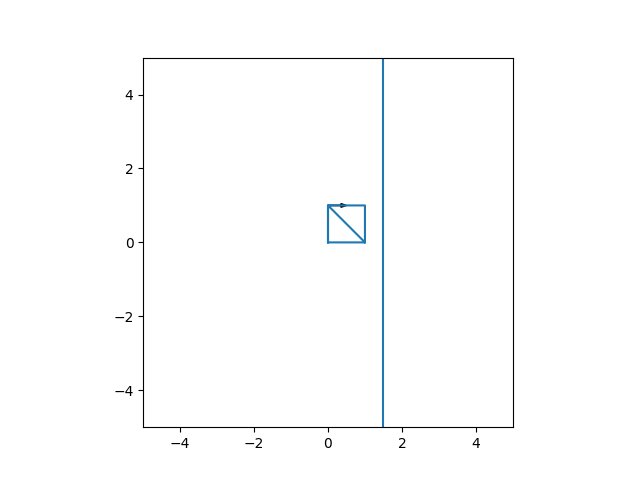

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import animation

def get_triangle_coords(q):
    return ([q[0], q[2], q[4], q[0]], [q[1], q[3], q[5], q[1]])

def get_net_coords(q):
    return ([q[0], q[2], q[4], q[0], q[4], q[6], q[2]], [q[1], q[3], q[5], q[1], q[5], q[7], q[3]])

fig, ax = plt.subplots()
ax.axvline(1.5)
ax.set_aspect('equal')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
# tri, = ax.plot(*get_triangle_coords(qs[0]))
net, = ax.plot(*get_net_coords(qs[0]))
arrow = ax.arrow(qs[0,4], qs[0,5], Q[0,4], Q[0,5], length_includes_head=True, head_width=.1)


def update(frame):
    # tri.set_data(*get_triangle_coords(qs[frame]))
    net.set_data(*get_net_coords(qs[frame]))
    arrow.set_data(x=qs[frame, 4], y=qs[frame, 5], dx=Q[frame, 4], dy=Q[frame,5])
    return net, arrow,

ani = animation.FuncAnimation(fig, update, frames=simulation_steps, interval=int(dt*1000))
# ani.save('triangle_animation.mp4')


In order to generalize the hydrostat model for cells that are not simplices (not triangles, tetrahedrons, etc) and for 3D polytopes, it is necessary to define general volume constraints, facet constraints (planar points must remain planar), and self intersection constraints (vertices going through arm edges). 

## General volume calculation
There are three proposed methods of calculating the volume constraint.
1. Use the Qhull methods via scipy wrapper. Pros: out of the box way to calculate volume. Cons: unable to update point coordinates, so new objects must be created for each cell at each time step. Probably slow. Also, not easily differentiable for calculating the Jacobian.
2. Triangulate the shape into simplices, calculate each individual tetrahedron, and then sum the volumes. Pros: Triangulation can be done once at initialization and the point sets stored for iterating. Caclulating the volume of tetrahedrons is simple. Number of calculations scales linearly with the number of vertices. Cons: Need to figure out how to break into simplices.
3. Break the solid into pyramids, calculate the volume of each pyramid, and then sum the volumes. Pros: Point sets can be determined at initialization. Calculations scale a little less than linearly with the number of vertices since only the area calculations would scale with vertices. Volume calculations would scale with facets. Cons: Not entirely sure how the differentiating the dot product necessary in this calculation would work. 

## Facet Constraints
Certain points would need to stay on the same facet. This can be done by specifying that the volume of the facet must be zero. Then one of the three methods listed in the volume calculation section can be used.

Could also calculate if relative vectors to a single point are all orthogonal to the face's normal vector.

## Self Intersection
In order to prevent vertices from going through edges, we can add half-space constraints for each vertex and edge pair. This is rather coputationally expensive but maybe it's okay? Grows at V x E.

In [30]:
import hydrostat_arm_3d
import importlib
import numpy as np

import polytopes

importlib.reload(hydrostat_arm_3d)
importlib.reload(polytopes)

points = polytopes.Square.points
vertices = polytopes.Square.vertices
edges = polytopes.Square.edges
faces = polytopes.Square.faces

cell = hydrostat_arm_3d.HydrostatCell3D(vertices, edges, faces)
arm = hydrostat_arm_3d.HydrostatArm3D(points, [cell])

# arm.set_external_forces([0,1,2,3,4,5], [1, 0, 0])
arm.set_external_forces(0, [0, 0, 1])
# arm.calc_next_states(0.1)
# TODO figure out why prism doesn't deform to force. I think it's that the face constraint is too stable.


array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [33]:
arm.calc_next_states(0.05)

(array([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [34]:
import draw_nodes_3d
importlib.reload(draw_nodes_3d)
drawer = draw_nodes_3d.NodeDrawer3D(arm, 1/30)
drawer.main_loop(simulating = False)

SystemExit: 

c:\Users\Alex\Documents\_projTech\030_isochoric\MuscularHydrostat\venv\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [109]:
### Matrix Calculus blackboard
import numpy as np

points = np.array([
    [0, 0, .1],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
])
N = len(points)
centroid = np.average(points, axis=0)
off_points = points - centroid
covar = np.cov(off_points.T)

eigvals, eigvecs = np.linalg.eig(covar)
print(eigvals)

normal = eigvecs[:,np.argmin(eigvals)]
min_eigval = np.min(eigvals)
print(normal)

i = 0
j = 0
unit = np.zeros((3, 1))
unit[j] = 1
dcovar = 1/(N-1) * (unit @ off_points[i].reshape(1, -1) + off_points[i].reshape(-1, 1) @ unit.T)
print(dcovar)

deigvec = np.zeros(3)
# test if differentiating by element of covariance matrix
for eigval, eigvec in zip(eigvals, eigvecs.T):
    if eigval == min_eigval: continue
    deigvec += eigvec.reshape(1, -1) @ dcovar @ normal * eigvec / (min_eigval - eigval)
print(deigvec)

jacobian = (N-1)/N * unit.T @ normal + (points[i] - centroid).reshape(1, -1) @ deigvec
print("jac", jacobian)

# check by perturbing points
points[i, j] += .000001
centroid = np.average(points, axis=0)
off_points = points - centroid
covar = np.cov(off_points.T)
eigvals, eigvecs = np.linalg.eig(covar)
new_normal = eigvecs[:,np.argmin(eigvals)]
print((new_normal - normal) * 1000000)




[0.00082918 0.33333333 0.33500416]
[0.04999922 0.04999922 0.99749695]
[[-0.33333333 -0.16666667  0.025     ]
 [-0.16666667  0.          0.        ]
 [ 0.025       0.          0.        ]]
[ 0.00024766  0.02512258 -0.00127168]
jac [0.02471892]
[ 0.00024763  0.02512258 -0.00127167]


In [111]:
cumsum = 0
for point in points:
    cumsum += unit@(point - centroid).reshape(1, -1)
print(cumsum)

[[-2.22044605e-16  0.00000000e+00  6.93889390e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
